In [1]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np  
import pandas as pd 
import re        
import sqlite3   
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from sklearn.model_selection import train_test_split
from keras import backend as K 
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow
import warnings
import nltk
from tqdm import tqdm
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# COLAB CONFIG
# change colab flag to false if train using jupyter notebook
COLAB_FLAG = True
COLAB_FILEPATH = './drive/My Drive/4034-amazon-review-classification/' if COLAB_FLAG == True else './'
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [4]:
# import the attention folder
import sys
sys.path.insert(0,'./drive/My Drive/4034-amazon-review-classification')

In [5]:
# import the AttentionLayer class from attention.py
from attention import AttentionLayer

In [6]:
# import the training data
# using SQLite Table to read data.
con = sqlite3.connect(COLAB_FILEPATH + 'data/database.sqlite')
data_train_raw_ = pd.read_sql_query(""" SELECT * FROM Reviews """, con) 
print(data_train_raw_.shape)
data_train_raw_.head(3)

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [7]:
#Sorting data according to ProductId in ascending order
data_train_raw=data_train_raw_.sort_values('ProductId', 
                                           axis=0, 
                                           ascending=True, 
                                           inplace=False, 
                                           kind='quicksort', 
                                           na_position='last')

# remove duplication of entries
data_train_raw=data_train_raw.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, 
                                              keep='first', inplace=False)
print(f'Shape: {data_train_raw.shape}')

# Checking to see how much % of data still remains
print(f"percentage of data remains: {(data_train_raw['Id'].size*1.0)/(data_train_raw_['Id'].size*1.0)*100}")
#data_train_raw.head(3)

Shape: (393933, 10)
percentage of data remains: 69.29901100176971


In [8]:
# import the crawled data for prediction later (test data)
# read the test data
data_test_raw_ = pd.read_csv(COLAB_FILEPATH+'data/trip-advisor-comments.csv')
print(f'Shape of the dataset:{data_test_raw_.shape}')
data_test_raw_.head()

Shape of the dataset:(97190, 5)


,Restaurant Name,Restaurant Type,Reviewer's Name,Rating,Comment
0,Positano @ RP,"Italian, European",aisvslife98,5,I enjoyed my time here with my girlfriends! Fa...
1,Positano @ RP,"Italian, European",Odyssey44198198885,5,Wonderful and amazing service experience. Defi...
2,Positano @ RP,"Italian, European",Ninifazelin,5,Great food and wonderful service! Will definit...
3,Positano @ RP,"Italian, European",Amaliamazlan,5,Not my first time in Positano and definitely w...
4,Positano @ RP,"Italian, European",Shahzanstim,5,Excellent service from the staff. The beef was...


In [9]:
# remove duplication of entries
data_test_raw=data_test_raw_.drop_duplicates(subset={"Reviewer\'s Name","Comment"}, 
                                             keep='first', inplace=False)
print(f'Shape of the dataset:{data_test_raw.shape}')

Shape of the dataset:(88042, 5)


In [10]:
#data_test_raw = pd.read_csv(COLAB_FILEPATH + 'data/trip-advisor-comments-filtered.csv')
# create an empty dataframe
data_test = pd.DataFrame()

# to store only the required columns into the new dataframe
data_test['comments'] = data_test_raw['Comment']

print(data_test.shape)
print(data_test.dtypes)
data_test.head()

(88042, 1)
comments    object
dtype: object


,comments
0,I enjoyed my time here with my girlfriends! Fa...
1,Wonderful and amazing service experience. Defi...
2,Great food and wonderful service! Will definit...
3,Not my first time in Positano and definitely w...
4,Excellent service from the staff. The beef was...


In [11]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                  "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                  "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                  "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                  "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                  "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                  "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                  "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                  "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                  "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                  "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                  "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                  "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                  "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                  "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                  "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                  "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                  "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                  "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                  "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                  "you're": "you are", "you've": "you have"}


In [12]:
# remove the stop-words and store cleaned data in a separate file
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        #removing short word
        if len(i)>=3:                  
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [13]:
# clean the train dataset (amazon data)
cleaned_text = []
for t in tqdm(data_train_raw['Text']):
    cleaned_text.append(text_cleaner(t))

100%|██████████| 393933/393933 [01:48<00:00, 3645.03it/s]


In [14]:
# clean the test dataset (crawled data)
cleaned_text_test = []
for t in tqdm(data_test['comments']):
    cleaned_text_test.append(text_cleaner(t))

100%|██████████| 88042/88042 [00:20<00:00, 4217.16it/s]


In [15]:
# clean summary using contraction_mapping too for the summarised text
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data_train_raw['Summary']:
    cleaned_summary.append(summary_cleaner(t))

In [16]:
# create a new dataframe which only contains the main text and the summarised text
data = pd.DataFrame()
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)
print(data.shape)
data.head()

(393587, 2)


,cleaned_text,cleaned_summary
0,junei saw charming groupof roses beginto droop...,nice cadence catchy rhymes
1,fun way children learn months year learn poems...,chicken soup with rice months
2,grew reading sendak books watching really rosi...,love the book miss the hard cover version
3,get movie sound track sing along carol king gr...,classic
4,entertaining rhyming story cleaver catchy illu...,chicken soup with rice


In [17]:
# likewise, create a new dataframe for the test set
data_test = pd.DataFrame()
data_test['comments_cleaned'] = cleaned_text_test
data_test['comments_cleaned'].replace('', np.nan, inplace=True)
data_test.dropna(axis=0,inplace=True)
print(data_test.shape)
data_test.head()

(88040, 1)


,comments_cleaned
0,enjoyed time girlfriends fajar server gave rec...
1,wonderful amazing service experience definitel...
2,great food wonderful service definitely return...
3,first time positano definitely last amazing se...
4,excellent service staff beef tender risotto ni...


In [18]:
# subset train data due to resource limitations and training time
data_subset = data.sample(300000, replace=False)
print(data_subset.shape)
data_subset.head(3)

(300000, 2)


,cleaned_text,cleaned_summary
184482,fiber one great cereal tasty enough eaten mixe...,fiber one is great
303801,good description product roasted popular coffe...,great flavor
326833,pros energy shots really work ingredients list...,tastes great works great


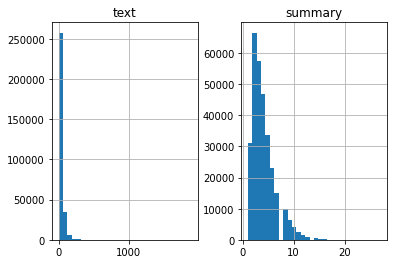

In [19]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []
text_word_count_test = []

# populate the lists with sentence lengths
for i in data_subset['cleaned_text']:
    text_word_count.append(len(i.split()))

for i in data_subset['cleaned_summary']:
    summary_word_count.append(len(i.split()))

for i in data_test['comments_cleaned']:
    text_word_count_test.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 
                          'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

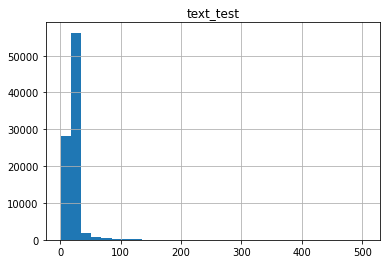

In [20]:
length_test_df = pd.DataFrame({'text_test':text_word_count_test})
length_test_df.hist(bins = 30)
plt.show()

In [21]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9452624197445546




We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.

In [22]:
max_text_len=50
max_summary_len=8

In [23]:
cleaned_text =np.array(data_subset['cleaned_text'])
cleaned_summary=np.array(data_subset['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [24]:
# do likewise for the test set
cleaned_text_test = np.array(data_test['comments_cleaned'])
short_text_test = []
for i in range(len(cleaned_text_test)):
    if(len(cleaned_text_test[i].split())<=max_text_len):
        short_text_test.append(cleaned_text_test[i])

df_test = pd.DataFrame({'text_test':short_text_test})

Remember to add the START and END special tokens at the beginning and end of the summary.  
Here, I have chosen sostok and eostok as START and END tokens

Note: Be sure that the chosen special tokens never appear in the summary

In [25]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [26]:
df.head(3)

,text,summary
0,fiber one great cereal tasty enough eaten mixe...,sostok fiber one is great eostok
1,good description product roasted popular coffe...,sostok great flavor eostok
2,bought doggie birthdays past absolutly loved f...,sostok great purchase eostok


In [27]:
df_test.head(3)

,text_test
0,enjoyed time girlfriends fajar server gave rec...
1,wonderful amazing service experience definitel...
2,great food wonderful service definitely return...


In [28]:
# export the train data
df.to_csv(COLAB_FILEPATH+'data/text_summarization_data_lite.csv', index=False)

In [29]:
# export the test data
df_test.to_csv(COLAB_FILEPATH+'data/text_summarization_data_test_lite.csv', index=False)

In [30]:
# import the train data for summarization
df = pd.read_csv(COLAB_FILEPATH+'data/text_summarization_data_lite.csv')
df.head(3)

,text,summary
0,fiber one great cereal tasty enough eaten mixe...,sostok fiber one is great eostok
1,good description product roasted popular coffe...,sostok great flavor eostok
2,bought doggie birthdays past absolutly loved f...,sostok great purchase eostok


In [31]:
# import the test data for prediction
df_test = pd.read_csv(COLAB_FILEPATH+'data/text_summarization_data_test_lite.csv')
df_test.head(3)

,text_test
0,enjoyed time girlfriends fajar server gave rec...
1,wonderful amazing service experience definitel...
2,great food wonderful service definitely return...


In [32]:
# split the data
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [33]:
# format the test set as well
x_test = np.array(np.array(df_test['text_test']))

In [34]:
x_tr = x_tr.astype(str)
x_val = x_val.astype(str)
x_test = x_test.astype(str)

# prepare tokenizer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))


In [35]:
# rarewords and its coverage
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 67.49428040597601
Total Coverage of rare words: 1.2096502777814262


Remember:

- tot_cnt gives the size of vocabulary (which means every unique words in the text)
- cnt gives me the no. of rare words whose count falls below threshold
- tot_cnt - cnt gives me the top most common words


In [36]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)
x_test_seq  =   x_tokenizer.texts_to_sequences(x_test)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
x_test  =   pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
x_voc

21171

In [37]:
len(x_tokenizer.index_word)

65127

In [38]:
# summary tokenizer
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [39]:
# rarewords and its coverage
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.57029900936108
Total Coverage of rare words: 2.499182056129126


In [40]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
y_voc

5377

In [41]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(204272, 204272)

In [42]:
# deleting the rows that contain ONLY start and end tokens
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [43]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)
x_test=np.delete(x_test,ind, axis=0)

In [44]:
x_tr.shape, y_tr.shape, x_val.shape, y_val.shape, x_test.shape

((201516, 50), (201516, 8), (22358, 50), (22358, 8), (85752, 50))

In [ ]:
# build model

We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

Initial State: This is used to initialize the internal states of the LSTM for the first timestep

Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Here, we are building a 3 stacked LSTM for the encoder:

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      2113400     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 300), (N 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
cp = ModelCheckpoint(filepath=COLAB_FILEPATH+'model/text-summarization.h5',save_best_only=True,verbose=1,)

In [ ]:
history=model.fit([x_tr,
                  y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=10,
                  callbacks=[es,cp],
                  batch_size=256,
                  validation_data=([x_val,y_val[:,:-1]],y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
788/788 [==============================] - 423s 524ms/step - loss: 3.2940 - val_loss: 2.6809

Epoch 00001: val_loss improved from inf to 2.68093, saving model to ./drive/My Drive/4034-amazon-review-classification/model/text-summarization.h5
Epoch 2/10
788/788 [==============================] - 411s 522ms/step - loss: 2.6371 - val_loss: 2.4659

Epoch 00002: val_loss improved from 2.68093 to 2.46586, saving model to ./drive/My Drive/4034-amazon-review-classification/model/text-summarization.h5
Epoch 3/10
788/788 [==============================] - 411s 521ms/step - loss: 2.4529 - val_loss: 2.3652

Epoch 00003: val_loss improved from 2.46586 to 2.36523, saving model to ./drive/My Drive/4034-amazon-review-classification/model/text-summarization.h5
Epoch 4/10
788/788 [==============================] - 412s 523ms/step - loss: 2.3431 - val_loss: 2.2861

Epoch 00004: val_loss improved from 2.36523 to 2.28607, saving model to ./drive/My Drive/4034-amazon-review-classification/model/te

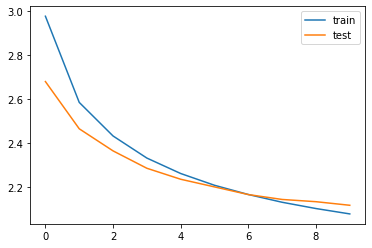

In [ ]:
# understanding the plot
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
model2 = tensorflow.keras.models.load_model(COLAB_FILEPATH+'model/text-summarization.h5', custom_objects={'AttentionLayer': AttentionLayer})

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
#reverse_source_word_index

In [ ]:
# inference
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# sample target word
target_word_index['add']

661

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if ((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
len(x_test)

85787

In [ ]:
# for the train set
for i in range(100,105):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: great tasting coffee strong earthy flavor even though comes already ground manages conserve rich bold smell highly recommend 
Original summary: excellent coffee 
Predicted summary:  great coffee


Review: kitten loves fancy feast first tried called healthy food core hated would touch eat core dry food canned food likes dare run meow gets dinner ingredients fine well like fancy feast adds vitamin supplements food 
Original summary: cat approved 
Predicted summary:  my cat loves this food


Review: little piece heaven earth new york wonderland frozen hot chocolate bought take home get better good winter summer must cannot get get frozen hot chocolate person please buy amazon 
Original summary: frozen hot chocolate 
Predicted summary:  best hot chocolate ever


Review: liked candies alot thought costly amt pieces got werent chocolate plain candy sticks 
Original summary: candy review 
Predicted summary:  candy


Review: product exactly wanted bought two jars gave one neighbor deli

In [ ]:
# for the val set
for i in range(100,105):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Review: color brown sugar shade darker regular dark brown sugar flavor bit different brown sugar seems richer complex delicious used baked beans recipe far best version baked beans ever made also delicious chocolate chip cookies tried dark brown muscovado since seems absolutely perfect brown sugar needs 
Original summary: best brown sugar ever 
Predicted summary:  excellent


Review: love make yes lazy wishbone also fat free version good tastes fuller brings enhances flavor salad ingredients 
Original summary: this has good flavor 
Predicted summary:  great for making chicken


Review: great idea pay candy decade chocolate caramel peanuts packaging salty goodness world yet see another candy carry name sports figure bring back reggie bar sell like 
Original summary: no bar 
Predicted summary:  delicious


Review: used bisquick forever celiacs use bisquick love little difference two made biscuits pot pie pancakes awesome find brands taste bisquick even daughter problem gluten loves think

In [ ]:
# for the test set
for i in range(100,105):
    print("Review:",seq2text(x_test[i]))
    print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_text_len)))
    print("\n")

Review: come eat flavours every month authentic flavours singapore service also good 
Predicted summary:  great product


Review: met friendly server name made dinner pleasant welcoming recommendation good dish delicious excellent throughout dinner also made sure dishes served timely warm also checked dessert served promptly another colleague also made stay visit welcoming friendly smile throughout dinner 
Predicted summary:  delicious


Review: nice restaurant beautiful decoration good food service kind friendly 
Predicted summary:  great gift


Review: visited restaurant birthday family originally found food authentic truly taste highly recommended 
Predicted summary:  delicious


Review: tables birthday celebration food amazing service great even restaurant quite full staff kind around tables provide good service would definitely recommend 
Predicted summary:  great gift




In [ ]:
test_text_list = []
test_summary_pred_list = []
# save the prediction summary for the test set
for i in tqdm(range(len(x_test))):
    test_text_list.append(seq2text(x_test[i]))
    test_summary_pred_list.append(decode_sequence(x_test[i].reshape(1,max_text_len)))

100%|██████████| 85787/85787 [4:36:59<00:00,  5.16it/s]


In [ ]:
# create new dataframe to see the comparison
test_df_ = pd.DataFrame()
test_df_['text'] = test_text_list
test_df_['pred_summary'] = test_summary_pred_list
print(test_df_.shape)
test_df_.head(3)

(85787, 2)


,text,pred_summary
0,enjoyed time girlfriends server gave recommend...,great gift
1,wonderful amazing service experience definitel...,excellent
2,great food wonderful service definitely return...,great product


In [ ]:
# save test analysis to csv
test_df_.to_csv(COLAB_FILEPATH+'data/text_summarization_data_test_analysis.csv', index=False)

In [ ]:
# do likewise for the validation set
val_text_list = []
val_summary_list = []
val_summary_pred_list = []
# save the prediction summary for the val set
for i in tqdm(range(len(x_val))):
    val_text_list.append(seq2text(x_val[i]))
    val_summary_list.append(seq2summary(y_val[i]))
    val_summary_pred_list.append(decode_sequence(x_val[i].reshape(1,max_text_len)))

100%|██████████| 22395/22395 [1:15:26<00:00,  4.95it/s]


In [ ]:
val_df_ = pd.DataFrame()
val_df_['text'] = val_text_list
val_df_['summary'] = val_summary_list
val_df_['pred_summary'] = val_summary_pred_list
print(val_df_.shape)
val_df_.head(3)

(22395, 3)


,text,summary,pred_summary
0,disappointing salty flavor shrimp made wheat r...,not shrimp chips,not what expected
1,didnt realize big going like cross vanilla ext...,great product,not what expected
2,buying product years ordering time agree peopl...,my wife loves it,best bread ever


In [ ]:
# save val analysis to csv
val_df_.to_csv(COLAB_FILEPATH+'data/text_summarization_data_val_analysis.csv', index=False)

In [45]:
# retrieve data from processed dataframe
df_val = pd.read_csv(COLAB_FILEPATH+'data/text_summarization_data_val_analysis.csv')
df_val.head(10)

,text,summary,pred_summary
0,disappointing salty flavor shrimp made wheat r...,not shrimp chips,not what expected
1,didnt realize big going like cross vanilla ext...,great product,not what expected
2,buying product years ordering time agree peopl...,my wife loves it,best bread ever
3,tried southern california cannot find anywhere...,best natural jerkey,great for low carb diets
4,really like rest family eat like cinnamon flak...,good snack,good flavor
5,first bought knowing expect love brown rice si...,excellent product,great rice
6,shipper packed envelope instead box little bub...,arrived broken and leaking,not as advertised
7,many years ago bought coconut cream flavored c...,the best coffee ever,best coffee ever
8,love tea like drinking liquid red hots hate he...,love it,great tea
9,sell cups containing coffee starbucks filled c...,mini cups for mini flavor,great decaf


In [46]:
# retrieve data from processed dataframe
df_test = pd.read_csv(COLAB_FILEPATH+'data/text_summarization_data_test_analysis.csv')
df_test.head(10)

,text,pred_summary
0,enjoyed time girlfriends server gave recommend...,great gift
1,wonderful amazing service experience definitel...,excellent
2,great food wonderful service definitely return...,great product
3,first time definitely last amazing service del...,delicious
4,excellent service staff beef tender risotto ni...,great product
5,place great food great staff friendly shout pl...,great product
6,best place chill business enviroment complete ...,best ever
7,love risotto third time coming last highly rec...,great product
8,food service everything great must try pizza u...,pizza pizza crust
9,great food love pasta milk shake staff attenti...,great for baby
